In [1]:
import numpy as np
import pandas as pd

# Generate mock categorical dataset
np.random.seed(42)
n_samples = 1000

source_data = pd.DataFrame({
    'income': np.random.choice(['low', 'medium', 'high'], size=n_samples, p=[0.3, 0.5, 0.2]),
    'education': np.random.choice(['primary', 'secondary', 'tertiary'], size=n_samples, p=[0.2, 0.5, 0.3]),
    'age_group': np.random.choice(['18-30', '31-45', '46-60', '61+'], size=n_samples, p=[0.25, 0.35, 0.25, 0.15])
})

print("✅ Source categorical data created!")
print(source_data.head())


✅ Source categorical data created!
   income  education age_group
0  medium    primary     31-45
1    high  secondary     18-30
2  medium   tertiary       61+
3  medium   tertiary     18-30
4     low   tertiary     31-45


In [2]:
def compute_ecdf_mappings(data):
    """
    Compute ECDF mappings for categorical variables.

    Parameters:
    -----------
    data : pd.DataFrame
        Categorical dataset.

    Returns:
    --------
    dict
        Mapping of categorical values to numerical ECDF space.
    """
    ecdf_mappings = {}

    for column in data.columns:
        unique_values = sorted(data[column].unique())
        ecdf_x = np.array(unique_values)
        ecdf_y = np.linspace(0, 1, len(ecdf_x), endpoint=False)

        ecdf_mappings[column] = {'x': ecdf_x, 'y': ecdf_y}

    return ecdf_mappings

# Compute ECDF mappings
ecdf_mappings = compute_ecdf_mappings(source_data)
print("✅ ECDF mappings computed!")
print(ecdf_mappings)


✅ ECDF mappings computed!
{'income': {'x': array(['high', 'low', 'medium'], dtype='<U6'), 'y': array([0.        , 0.33333333, 0.66666667])}, 'education': {'x': array(['primary', 'secondary', 'tertiary'], dtype='<U9'), 'y': array([0.        , 0.33333333, 0.66666667])}, 'age_group': {'x': array(['18-30', '31-45', '46-60', '61+'], dtype='<U5'), 'y': array([0.  , 0.25, 0.5 , 0.75])}}


In [3]:
def transform_to_copula_space(data, ecdf_mappings):
    """
    Transform categorical data into copula space using ECDF mappings.

    Parameters:
    -----------
    data : pd.DataFrame
        Categorical dataset.
    ecdf_mappings : dict
        ECDF mappings.

    Returns:
    --------
    pd.DataFrame
        Transformed data in copula space [0,1]^d.
    """
    copula_data = pd.DataFrame()

    for column in data.columns:
        mapping = ecdf_mappings[column]
        copula_data[column] = data[column].map(dict(zip(mapping['x'], mapping['y'])))

    return copula_data

# Transform source data to copula space
copula_data = transform_to_copula_space(source_data, ecdf_mappings)
print("✅ Data transformed to copula space!")
print(copula_data.head())


✅ Data transformed to copula space!
     income  education  age_group
0  0.666667   0.000000       0.25
1  0.000000   0.333333       0.00
2  0.666667   0.666667       0.75
3  0.666667   0.666667       0.00
4  0.333333   0.666667       0.25


In [4]:
from ctgan import CTGAN

def generate_synthetic_copula_data(copula_data, n_samples=1000):
    """
    Train a CTGAN model and generate synthetic copula samples.

    Parameters:
    -----------
    copula_data : pd.DataFrame
        Data transformed into copula space.
    n_samples : int
        Number of synthetic samples to generate.

    Returns:
    --------
    pd.DataFrame
        Synthetic copula data.
    """
    ctgan = CTGAN(epochs=500)
    ctgan.fit(copula_data)

    synthetic_samples = ctgan.sample(n_samples)
    return synthetic_samples

# Generate synthetic copula data
synthetic_copula_data = generate_synthetic_copula_data(copula_data)
print("✅ Synthetic copula data generated!")
print(synthetic_copula_data.head())


✅ Synthetic copula data generated!
     income  education  age_group
0  0.670194   0.349092   0.509227
1  0.672138   0.648828   0.459800
2  0.330135   0.348462   0.502397
3  0.313690   0.346267   0.726096
4  0.679623   0.338715   0.024187


In [19]:
target_marginals = {
    'income': {'low': 0.4, 'medium': 0.3, 'high': 0.3},
    'education': {'primary': 0.15, 'secondary': 0.5, 'tertiary': 0.35},
    'age_group': {'18-30': 0.2, '31-45': 0.3, '46-60': 0.3, '61+': 0.2}
}

print("✅ Target marginal distributions defined!")

✅ Target marginal distributions defined!


In [21]:
import numpy as np
import pandas as pd

def adjust_copula_to_match_marginals(synthetic_copula_data, target_marginals, ecdf_mappings):
    """
    Adjust synthetic copula samples to match the given marginal distributions 
    using the inverse CDF method from the paper.

    Parameters:
    -----------
    synthetic_copula_data : pd.DataFrame
        Synthetic data in copula space [0,1]^d.
    target_marginals : dict
        Dictionary of target marginal distributions (probabilities) for each attribute.
    ecdf_mappings : dict
        ECDF mappings from original seed data to ensure smooth transformation.

    Returns:
    --------
    pd.DataFrame
        Adjusted synthetic copula data still in [0,1]^d.
    """
    print("📌 Adjusting copula data using inverse CDF method...")

    adjusted_copula_data = synthetic_copula_data.copy()

    for column in synthetic_copula_data.columns:
        u_values = synthetic_copula_data[column].values  # Copula values in [0,1]

        # Convert categorical values in ECDF to numeric (index-based mapping)
        category_to_num = {cat: idx / (len(ecdf_mappings[column]['x']) - 1) for idx, cat in enumerate(ecdf_mappings[column]['x'])}
        num_to_category = {idx / (len(ecdf_mappings[column]['x']) - 1): cat for idx, cat in enumerate(ecdf_mappings[column]['x'])}

        # Convert target marginal categories to numeric
        target_values_numeric = np.array([category_to_num[cat] for cat in target_marginals[column].keys()])
        target_probs = np.array(list(target_marginals[column].values()))
        target_cdf = np.cumsum(target_probs)  # Compute CDF

        # Apply the inverse CDF transformation: find the smallest category where CDF ≥ u
        adjusted_u_values = np.interp(u_values, np.linspace(0, 1, len(target_cdf)), target_cdf)

        # Map back using numerical ECDF scale
        mapped_values = np.interp(adjusted_u_values, target_cdf, target_values_numeric)

        # Normalize adjusted values back to [0,1]
        adjusted_copula_data[column] = (mapped_values - mapped_values.min()) / (mapped_values.max() - mapped_values.min() + 1e-10)

    print("✅ Copula data successfully adjusted while preserving [0,1] structure!")
    return adjusted_copula_data


# Adjust synthetic copula data
adjusted_synthetic_copula_data = adjust_copula_to_match_marginals(synthetic_copula_data, target_marginals, ecdf_mappings)
print("✅ Synthetic copula data adjusted to match target marginals!")


📌 Adjusting copula data using inverse CDF method...
✅ Copula data successfully adjusted while preserving [0,1] structure!
✅ Synthetic copula data adjusted to match target marginals!


In [22]:
def map_back_to_original(adjusted_copula_data, ecdf_mappings):
    """
    Convert numerical copula data back to original categorical values.

    Parameters:
    -----------
    adjusted_copula_data : pd.DataFrame
        Data adjusted in copula space [0,1]^d.
    ecdf_mappings : dict
        ECDF mappings to map back to categorical values.

    Returns:
    --------
    pd.DataFrame
        Final synthetic categorical data.
    """
    categorical_data = pd.DataFrame()

    for column in adjusted_copula_data.columns:
        ecdf_x = ecdf_mappings[column]['x']
        ecdf_y = ecdf_mappings[column]['y']
        categorical_data[column] = [ecdf_x[np.searchsorted(ecdf_y, u, side="right") - 1] for u in adjusted_copula_data[column].values]

    return categorical_data

# Convert back to categorical values
final_synthetic_data = map_back_to_original(adjusted_synthetic_copula_data, ecdf_mappings)
print("✅ Final synthetic data mapped back to categorical values!")
print(final_synthetic_data.head())

✅ Final synthetic data mapped back to categorical values!
   income  education age_group
0     low  secondary     46-60
1     low   tertiary     46-60
2  medium  secondary     46-60
3  medium  secondary       61+
4     low  secondary     18-30


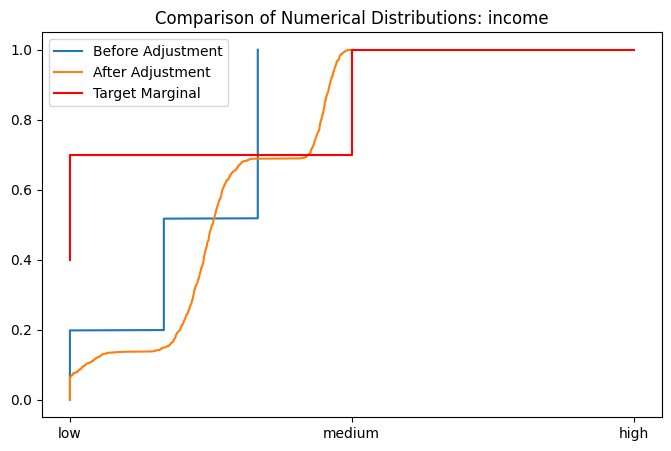

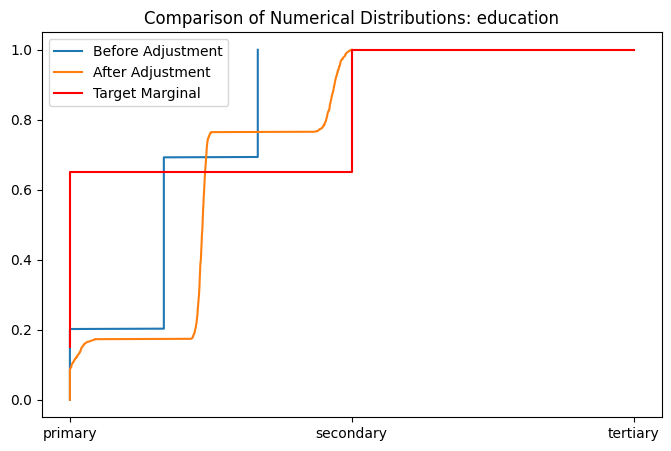

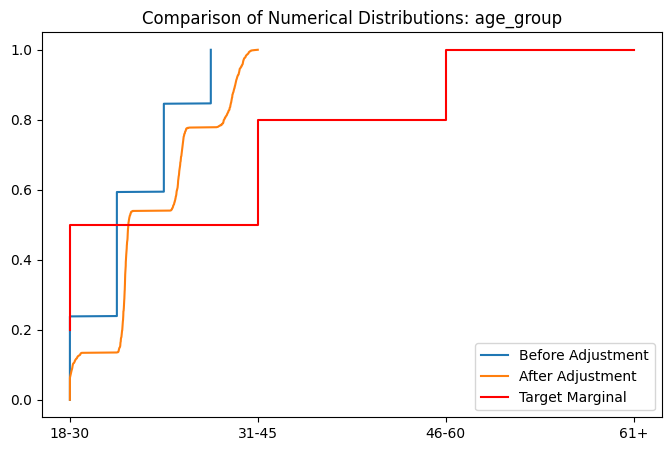

In [23]:
import matplotlib.pyplot as plt

def plot_distribution_comparison(original, adjusted, target, column):
    plt.figure(figsize=(8,5))

    # Original ECDF
    plt.plot(np.sort(original), np.linspace(0, 1, len(original)), label="Before Adjustment")

    # Adjusted ECDF
    plt.plot(np.sort(adjusted), np.linspace(0, 1, len(adjusted)), label="After Adjustment")

    # Target Marginal Distribution (Mapped)
    plt.step(list(target.keys()), np.cumsum(list(target.values())), label="Target Marginal", color="red")

    plt.title(f"Comparison of Numerical Distributions: {column}")
    plt.legend()
    plt.show()

for col in source_data.columns:
    plot_distribution_comparison(copula_data[col], adjusted_synthetic_copula_data[col], target_marginals[col], col)

In [24]:
def compute_categorical_distributions(seed_data, before_adjustment_data, after_adjustment_data, target_marginals):
    """
    Compute categorical distributions (proportions) for seed data, synthetic data before and after adjustment, and target marginal.

    Parameters:
    -----------
    seed_data : pd.DataFrame
        The original raw categorical data.
    before_adjustment_data : pd.DataFrame
        Synthetic categorical data before marginal adjustment.
    after_adjustment_data : pd.DataFrame
        Synthetic categorical data after marginal adjustment.
    target_marginals : dict
        Target marginal distributions.

    Returns:
    --------
    dict
        Dictionary of distributions for each attribute.
    """
    distributions = {}

    for column in seed_data.columns:
        seed_dist = seed_data[column].value_counts(normalize=True).sort_index()
        before_dist = before_adjustment_data[column].value_counts(normalize=True).sort_index()
        after_dist = after_adjustment_data[column].value_counts(normalize=True).sort_index()
        target_dist = pd.Series(target_marginals[column]).sort_index()

        distributions[column] = {
            'Seed': seed_dist,
            'Before Adjustment': before_dist,
            'After Adjustment': after_dist,
            'Target': target_dist
        }

    return distributions

# Compute distributions
categorical_distributions = compute_categorical_distributions(
    seed_data=source_data, 
    before_adjustment_data=map_back_to_original(synthetic_copula_data, ecdf_mappings),
    after_adjustment_data=final_synthetic_data, 
    target_marginals=target_marginals
)

# Print distributions
for col, dist in categorical_distributions.items():
    print(f"\n📊 {col} Distribution Comparison:")
    print("Seed Data:\n", dist['Seed'])
    print("Before Adjustment:\n", dist['Before Adjustment'])
    print("After Adjustment:\n", dist['After Adjustment'])
    print("Target Marginal:\n", dist['Target'])



📊 income Distribution Comparison:
Seed Data:
 income
high      0.199
low       0.319
medium    0.482
Name: proportion, dtype: float64
Before Adjustment:
 income
high      0.263
low       0.466
medium    0.271
Name: proportion, dtype: float64
After Adjustment:
 income
high      0.149
low       0.540
medium    0.311
Name: proportion, dtype: float64
Target Marginal:
 high      0.3
low       0.4
medium    0.3
dtype: float64

📊 education Distribution Comparison:
Seed Data:
 education
primary      0.203
secondary    0.490
tertiary     0.307
Name: proportion, dtype: float64
Before Adjustment:
 education
primary      0.355
secondary    0.440
tertiary     0.205
Name: proportion, dtype: float64
After Adjustment:
 education
primary      0.174
secondary    0.591
tertiary     0.235
Name: proportion, dtype: float64
Target Marginal:
 primary      0.15
secondary    0.50
tertiary     0.35
dtype: float64

📊 age_group Distribution Comparison:
Seed Data:
 age_group
18-30    0.239
31-45    0.355
46-60    

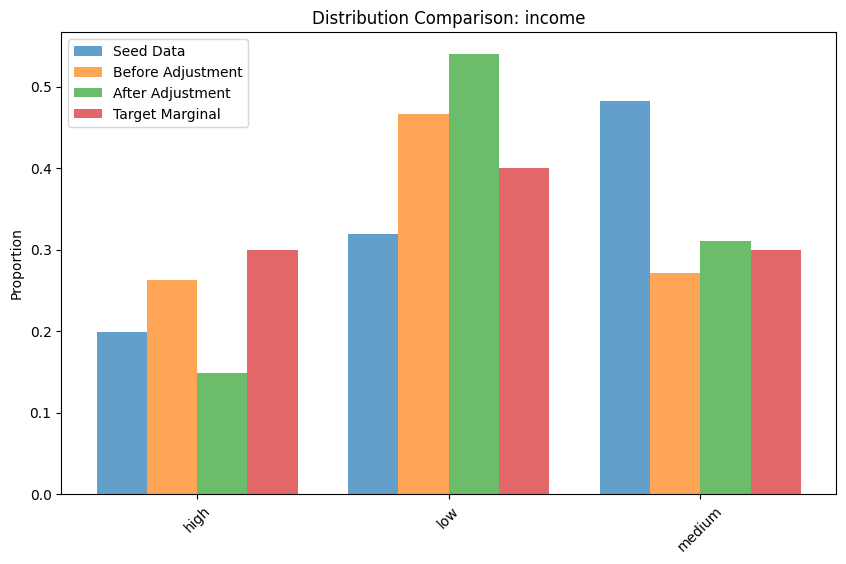

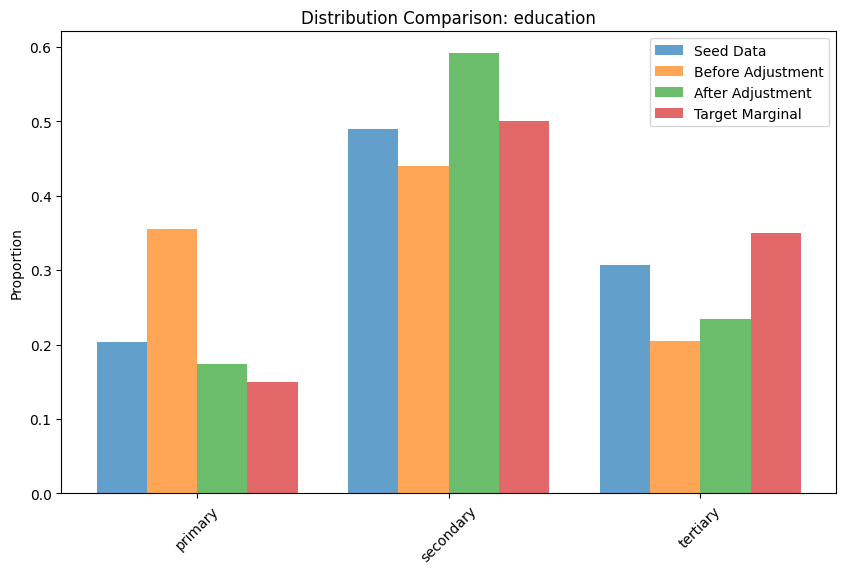

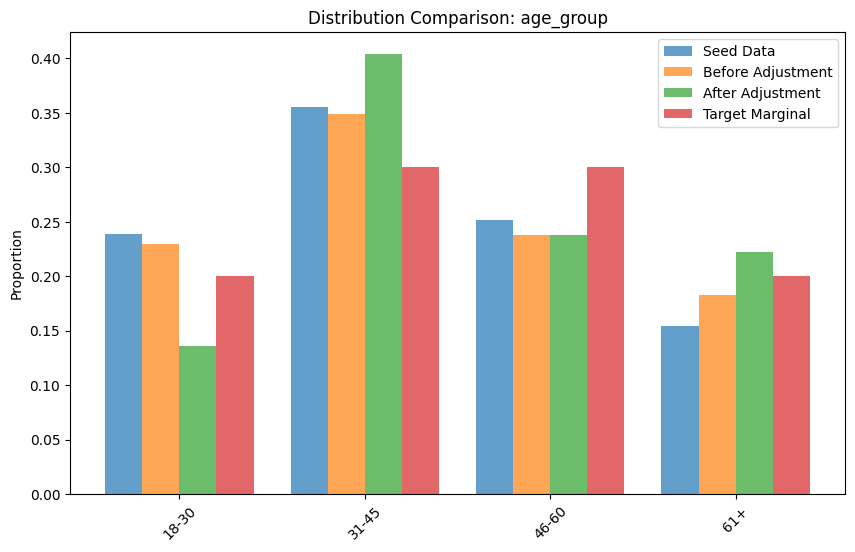

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_categorical_distributions(distributions):
    """
    Plot categorical distributions for seed data, synthetic before adjustment, after adjustment, and target marginals.

    Parameters:
    -----------
    distributions : dict
        Dictionary of categorical distributions.
    """
    for column, dist in distributions.items():
        categories = sorted(set(dist['Seed'].index) | set(dist['Before Adjustment'].index) | 
                            set(dist['After Adjustment'].index) | set(dist['Target'].index))

        seed_values = [dist['Seed'].get(cat, 0) for cat in categories]
        before_values = [dist['Before Adjustment'].get(cat, 0) for cat in categories]
        after_values = [dist['After Adjustment'].get(cat, 0) for cat in categories]
        target_values = [dist['Target'].get(cat, 0) for cat in categories]

        x = np.arange(len(categories))  # Label positions
        width = 0.2  # Width of bars

        plt.figure(figsize=(10, 6))
        plt.bar(x - 1.5*width, seed_values, width, label="Seed Data", alpha=0.7)
        plt.bar(x - 0.5*width, before_values, width, label="Before Adjustment", alpha=0.7)
        plt.bar(x + 0.5*width, after_values, width, label="After Adjustment", alpha=0.7)
        plt.bar(x + 1.5*width, target_values, width, label="Target Marginal", alpha=0.7)

        plt.xticks(ticks=x, labels=categories, rotation=45)
        plt.ylabel("Proportion")
        plt.title(f"Distribution Comparison: {column}")
        plt.legend()
        plt.show()

# Plot categorical distributions
plot_categorical_distributions(categorical_distributions)


In [26]:
from sklearn.metrics import mean_squared_error

def compute_rmse_scores(distributions):
    """
    Compute RMSE between synthetic distributions (before & after adjustment) and the target marginal.

    Parameters:
    -----------
    distributions : dict
        Dictionary containing categorical distributions.

    Returns:
    --------
    dict
        RMSE scores for before and after adjustment.
    """
    rmse_scores = {}

    for column, dist in distributions.items():
        # Align categories across all distributions
        categories = sorted(set(dist['Seed'].index) | set(dist['Before Adjustment'].index) | 
                            set(dist['After Adjustment'].index) | set(dist['Target'].index))

        before_values = np.array([dist['Before Adjustment'].get(cat, 0) for cat in categories])
        after_values = np.array([dist['After Adjustment'].get(cat, 0) for cat in categories])
        target_values = np.array([dist['Target'].get(cat, 0) for cat in categories])

        # Compute RMSE
        rmse_before = np.sqrt(mean_squared_error(target_values, before_values))
        rmse_after = np.sqrt(mean_squared_error(target_values, after_values))

        rmse_scores[column] = {
            'RMSE Before Adjustment': rmse_before,
            'RMSE After Adjustment': rmse_after
        }

    return rmse_scores

# Compute RMSE
rmse_results = compute_rmse_scores(categorical_distributions)

# Print RMSE Scores
print("\n📉 RMSE Scores for Adjustment:")
for col, scores in rmse_results.items():
    print(f"{col}:")
    print(f"  RMSE Before Adjustment: {scores['RMSE Before Adjustment']:.6f}")
    print(f"  RMSE After Adjustment: {scores['RMSE After Adjustment']:.6f}")
    print(f"  🔻 Improvement: {scores['RMSE Before Adjustment'] - scores['RMSE After Adjustment']:.6f}")




📉 RMSE Scores for Adjustment:
income:
  RMSE Before Adjustment: 0.046783
  RMSE After Adjustment: 0.119055
  🔻 Improvement: -0.072271
education:
  RMSE Before Adjustment: 0.149053
  RMSE After Adjustment: 0.085794
  🔻 Improvement: 0.063258
age_group:
  RMSE Before Adjustment: 0.043110
  RMSE After Adjustment: 0.069354
  🔻 Improvement: -0.026244
